In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import provided modules
from ev_core import EVStagHuntModel
import ev_experiments as exp
import ev_plotting as evplot

# Ensure plots directory exists
os.makedirs("plots", exist_ok=True)

# Global Configuration for Reproducibility [cite: 32]
# N=200 is chosen as a trade-off between computational speed and network complexity.
# T=250 is chosen to ensure the system has time to reach equilibrium.
GLOBAL_N = 200 
GLOBAL_T = 250
SEED_BASE = 42

print("Environment configured.")

Environment configured.


In [2]:
# 1.1 Phase Plot: X* vs (X0, Ratio)
# This addresses the rubric requirement to find "evidence of tipping" and "bistability".

print("Running Phase Sweep (this may take a minute)...")

# We sweep X0 from 0 to 1, and the Payoff Ratio from 0.8 to 3.5
phase_df = exp.phase_sweep_df(
    X0_values=np.linspace(0.0, 1.0, 41),
    ratio_values=np.linspace(0.8, 3.5, 41),
    scenario_kwargs={
        "n_nodes": GLOBAL_N,
        "network_type": "random", # Using Random (ER) for baseline
        "p": 0.05,
        "I0": 0.05,
        "beta_I": 2.0  # Moderate infrastructure feedback
    },
    T=GLOBAL_T,
    batch_size=10, # Average over 10 seeds per point
    max_workers=4   # Adjust based on your CPU
)

Running Phase Sweep (this may take a minute)...


Sweeping Phase Space:   0%|          | 0/16810 [00:00<?, ?it/s]

Phase plot saved to plots/1_baseline_phase_plot.png


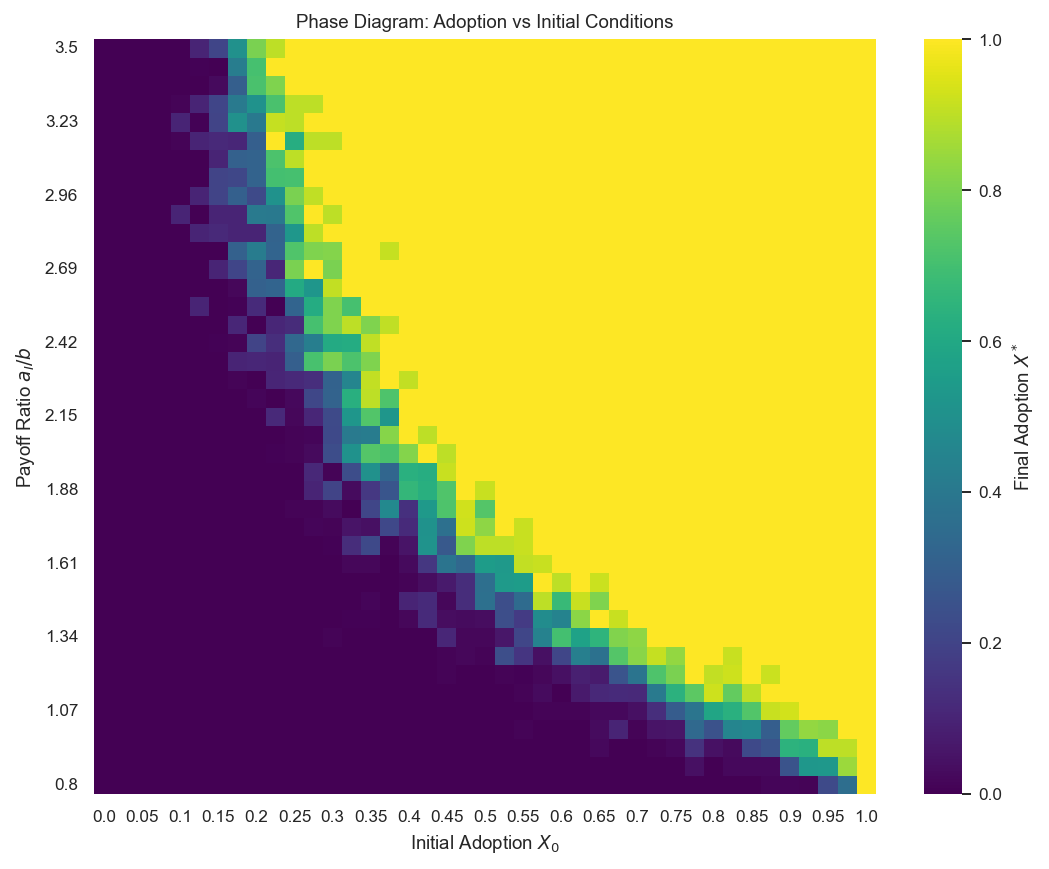

In [3]:
# Plotting
plot_path = evplot.plot_phase_plot(phase_df, out_path="plots/1_baseline_phase_plot.png")
print(f"Phase plot saved to {plot_path}")

# Display for notebook
from IPython.display import Image
display(Image(filename=plot_path))

Running Beta_I Sensitivity (Guaranteed Split)...


C:\Users\jfresen\AppData\Local\Temp\ipykernel_7336\3841354210.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=beta_df, x="beta", y="final_X", palette="viridis")


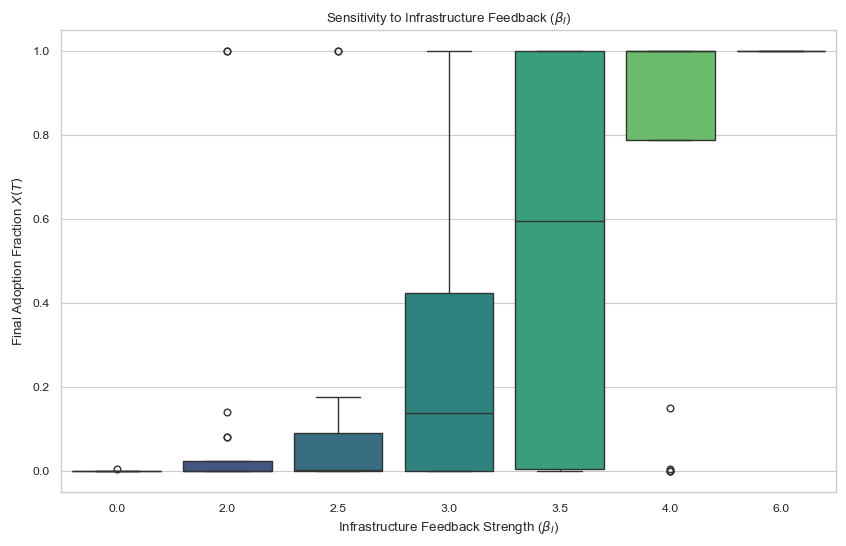

In [4]:
# 1.2 Sensitivity Analysis: Varying Beta_I (GUARANTEED SPLIT)
# We set intrinsic quality LOW (1.1) so it fails without help.
# We set initial infra HIGH (0.25) so Beta has a huge effect.

beta_values = [0.0, 2.0, 2.5, 3.0, 3.5, 4.0, 6.0]
results = []

print("Running Beta_I Sensitivity (Guaranteed Split)...")

for beta in beta_values:
    for i in range(20): 
        # Manually ensure ratio is None to prevent overriding a0
        scenario = {
            "n_nodes": GLOBAL_N,
            "network_type": "random", 
            "beta_I": beta,
            "ratio": None,    # DISABLED
            "a0": 1.1,        # Intrinsic: Barely better than gas (1.0). 
                              # Without coordination, this is a guaranteed FAIL.
            "b": 1.0,       
            "X0_frac": 0.4,   # Start at 40% adoption
            "I0": 0.25,       # Start with 25% infrastructure
            "g_I": 0.1,
        }
        
        X, I, df = exp.run_timeseries_trial(
            T=GLOBAL_T,
            scenario_kwargs=scenario,
            seed=SEED_BASE + i + 9999
        )
        results.append({"beta": beta, "final_X": X[-1]})

beta_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=beta_df, x="beta", y="final_X", palette="viridis")
plt.title("Sensitivity to Infrastructure Feedback ($\u03b2_I$)")
plt.ylabel("Final Adoption Fraction $X(T)$")
plt.xlabel("Infrastructure Feedback Strength ($\u03b2_I$)")
plt.ylim(-0.05, 1.05)

# Save
plt.savefig("plots/1_beta_sensitivity_guaranteed.png", dpi=140)
plt.show()